In [2]:
# ================================================================
# 🪴 Medicinal Leaf Classification - Flask-Ready Model (Fixed)
# Classes: Mango, Neem, Guava, Lemon
# Authors: (Ayuen, Malith, Deng, Biar & Akot)
# ================================================================
# =============================================================================
# 1. ENVIRONMENT SETUP & CONFIGURATION
# =============================================================================
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.utils import to_categorical

# Deep Learning Imports
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

# Architectures
from tensorflow.keras.applications import MobileNetV2, ResNet50, EfficientNetB7

# Specific Preprocessing Functions
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_prep
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_prep
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_prep

# --- GLOBAL CONFIGURATION ---
CONF = {
    "DATASET_PATH": '/kaggle/input/indian-medicinal-leaves-dataset/Indian Medicinal Leaves Image Datasets/Medicinal Leaf dataset',
    "TARGET_CLASSES": ['Mango', 'Neem', 'Guava', 'Lemon'],
    "IMG_SIZE": (224, 224),
    "BATCH_SIZE": 16, # Kept low for memory safety
    "EPOCHS": 15,
    "SEED": 42
}

print(f"✅ TensorFlow Version: {tf.__version__}")
print(f"✅ GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

✅ TensorFlow Version: 2.18.0
✅ GPU Available: True



--- Phase 1: Data Ingestion & Splitting ---
📊 Total Images Found: 486
   Train Set: 340 images
   Val Set:   73 images
   Test Set:  73 images

--- Generating Sample Visualizations ---


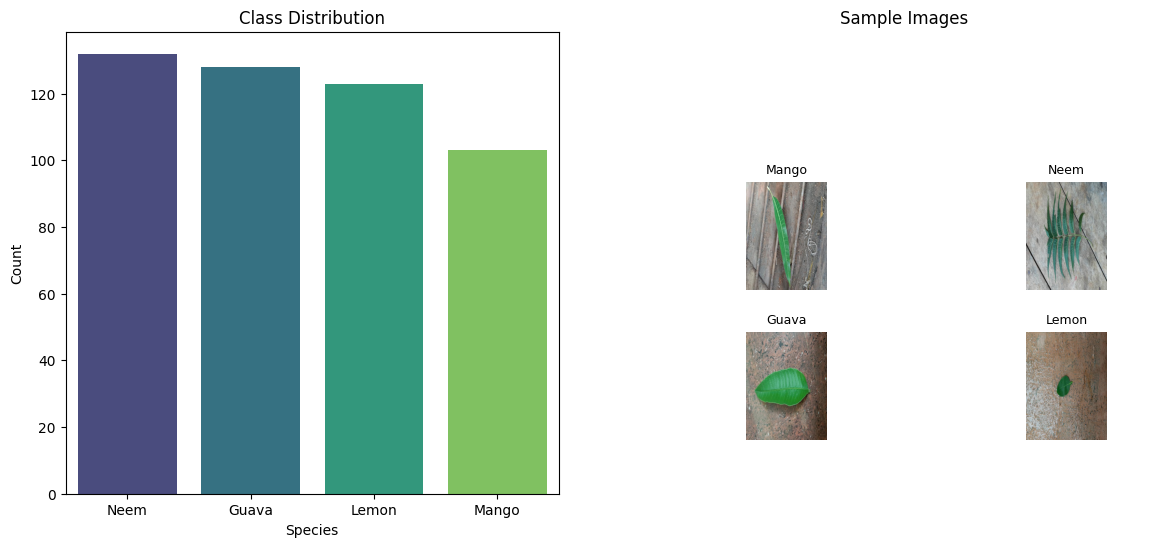

In [4]:
# =============================================================================
# 2. DATA PREPARATION & EXPLORATORY DATA ANALYSIS (EDA)
# =============================================================================
print("\n--- Phase 1: Data Ingestion & Splitting ---")

# A. Data Inventory
filepaths = []
labels = []

if not os.path.exists(CONF["DATASET_PATH"]):
    print(f"❌ ERROR: Dataset path not found: {CONF['DATASET_PATH']}")
else:
    for category in os.listdir(CONF["DATASET_PATH"]):
        if category in CONF["TARGET_CLASSES"]:
            folder_path = os.path.join(CONF["DATASET_PATH"], category)
            for file in os.listdir(folder_path):
                if file.lower().endswith(('.jpg', '.jpeg', '.png', '.webp')):
                    filepaths.append(os.path.join(folder_path, file))
                    labels.append(category)

# Create DataFrame
df = pd.DataFrame({'file_path': filepaths, 'species': labels})
print(f"📊 Total Images Found: {len(df)}")

# Save Metadata CSV
df.to_csv('medicinal_plant_metadata.csv', index=False)

# B. Stratified Split (70% Train, 15% Val, 15% Test)
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['species'], random_state=CONF["SEED"])
val_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df['species'], random_state=CONF["SEED"])

print(f"   Train Set: {len(train_df)} images")
print(f"   Val Set:   {len(val_df)} images")
print(f"   Test Set:  {len(test_df)} images")

# C. EDA Visualization
print("\n--- Generating Sample Visualizations ---")
plt.figure(figsize=(14, 6))

# Subplot 1: Class Distribution
plt.subplot(1, 2, 1)
sns.countplot(x='species', data=df, palette='viridis')
plt.title("Class Distribution")
plt.xlabel("Species")
plt.ylabel("Count")

# Subplot 2: Sample Images
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title("Sample Images")
for i, species in enumerate(CONF["TARGET_CLASSES"]):
    sample = df[df['species'] == species].sample(1).iloc[0]
    img = cv2.imread(sample['file_path'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Create a small grid inside the plot
    ax = plt.gcf().add_axes([0.55 + (i%2)*0.2, 0.45 - (i//2)*0.25, 0.18, 0.18])
    ax.imshow(img)
    ax.set_title(species, fontsize=9)
    ax.axis('off')

plt.show()

In [5]:
# =============================================================================
# 3. MULTI-MODEL TRAINING & SELECTION
# =============================================================================
print("\n--- Phase 2: Model Training Loop ---")

# Config: (ModelClass, PreprocessingFunc, RescaleFactor)
models_config = {
    'Baseline_CNN':   (None, None, 1./255),
    'MobileNetV2':    (MobileNetV2, mobilenet_prep, None),
    'ResNet50':       (ResNet50, resnet_prep, None), 
    'EfficientNetB7': (EfficientNetB7, efficientnet_prep, None)
}

best_overall_acc = 0.0
best_model_name = ""
history_storage = {}

for name, (ModelArch, preprocess_func, rescale_val) in models_config.items():
    print(f"\n{'='*40}")
    print(f"🔄 TRAINING MODEL: {name}")
    print(f"{'='*40}")
    
    # 1. Dynamic Data Generators
    if preprocess_func:
        train_datagen = ImageDataGenerator(
            preprocessing_function=preprocess_func,
            rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
            horizontal_flip=True, fill_mode='nearest'
        )
        val_datagen = ImageDataGenerator(preprocessing_function=preprocess_func)
    else:
        train_datagen = ImageDataGenerator(
            rescale=rescale_val, rotation_range=20, horizontal_flip=True
        )
        val_datagen = ImageDataGenerator(rescale=rescale_val)
        
    train_gen = train_datagen.flow_from_dataframe(
        train_df, x_col='file_path', y_col='species',
        target_size=CONF["IMG_SIZE"], batch_size=CONF["BATCH_SIZE"], class_mode='categorical'
    )
    
    val_gen = val_datagen.flow_from_dataframe(
        val_df, x_col='file_path', y_col='species',
        target_size=CONF["IMG_SIZE"], batch_size=CONF["BATCH_SIZE"], class_mode='categorical', shuffle=False
    )
    
    # 2. Build Architecture
    if name == 'Baseline_CNN':
        model = models.Sequential([
            layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
            layers.MaxPooling2D((2,2)),
            layers.Conv2D(64, (3,3), activation='relu'),
            layers.MaxPooling2D((2,2)),
            layers.Conv2D(128, (3,3), activation='relu'),
            layers.GlobalAveragePooling2D(),
            layers.Dense(128, activation='relu'),
            layers.Dense(len(CONF["TARGET_CLASSES"]), activation='softmax')
        ])
    else:
        base_model = ModelArch(weights='imagenet', include_top=False, input_shape=(224,224,3))
        base_model.trainable = False # Frozen Feature Extraction
        
        model = models.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(len(CONF["TARGET_CLASSES"]), activation='softmax')
        ])
        
    # 3. Compile & Train
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    temp_model_path = f"temp_{name}.keras"
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ModelCheckpoint(temp_model_path, save_best_only=True, monitor='val_accuracy')
    ]
    
    history = model.fit(train_gen, validation_data=val_gen, epochs=CONF["EPOCHS"], callbacks=callbacks, verbose=1)
    history_storage[name] = history
    
    # 4. Evaluate & Compare
    model.load_weights(temp_model_path)
    loss, acc = model.evaluate(val_gen, verbose=0)
    print(f"--> {name} Validation Accuracy: {acc:.4f}")
    
    if acc > best_overall_acc:
        print(f"*** 🏆 NEW LEADER! {name} ***")
        best_overall_acc = acc
        best_model_name = name
        model.save('Best_Model.h5')
        with open('class_indices.pkl', 'wb') as f:
            pickle.dump(train_gen.class_indices, f)
            
print(f"\n✅ Training Complete. Best Model: {best_model_name} ({best_overall_acc:.4f})")


--- Phase 2: Model Training Loop ---

🔄 TRAINING MODEL: Baseline_CNN
Found 340 validated image filenames belonging to 4 classes.
Found 73 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1763893731.269945      39 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1763893735.561263     106 service.cc:148] XLA service 0x7a5d10086f00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763893735.562151     106 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763893735.888868     106 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:52 5s/step - accuracy: 0.1875 - loss: 1.3876

I0000 00:00:1763893738.418460     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 373ms/step - accuracy: 0.2615 - loss: 1.3934 - val_accuracy: 0.2740 - val_loss: 1.3806
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - accuracy: 0.3013 - loss: 1.3770 - val_accuracy: 0.3836 - val_loss: 1.3640
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - accuracy: 0.3047 - loss: 1.3556 - val_accuracy: 0.3973 - val_loss: 1.3095
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.3399 - loss: 1.3391 - val_accuracy: 0.3425 - val_loss: 1.3139
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step - accuracy: 0.4636 - loss: 1.2736 - val_accuracy: 0.4932 - val_loss: 1.2461
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 0.4206 - loss: 1.2149 - val_accuracy: 0.3699 - val_loss: 1.1655
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - accuracy: 0.3862 - loss: 1.2146 - val_accuracy: 0.4384 - val_loss: 1.2176
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - accuracy: 0.4445 - loss: 1.1930 - val_accuracy: 0.4795 - val

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 29s 734ms/step - accuracy: 0.3853 - loss: 2.0223 - val_accuracy: 0.8219 - val_loss: 0.4476
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 242ms/step - accuracy: 0.8124 - loss: 0.4677 - val_accuracy: 0.8904 - val_loss: 0.3618
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - accuracy: 0.9002 - loss: 0.2757 - val_accuracy: 0.8767 - val_loss: 0.3139
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 244ms/step - accuracy: 0.8872 - loss: 0.3050 - val_accuracy: 0.9452 - val_loss: 0.2270
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.8975 - loss: 0.2438 - val_accuracy: 0.9315 - val_loss: 0.1967
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step - accuracy: 0.9651 - loss: 0.1206 - val_accuracy: 0.9041 - val_loss: 0.2774
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step - accuracy: 0.9660 - loss: 0.1089 - val_accuracy: 0.8767 - val_loss: 0.2731
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 241ms/step - accuracy: 0.9520 - loss: 0.1555 - val_accuracy: 0

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.4660 - loss: 1.0441 - val_accuracy: 0.8082 - val_loss: 0.5240
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 362ms/step - accuracy: 0.8069 - loss: 0.4532 - val_accuracy: 0.8356 - val_loss: 0.3974
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.8904 - loss: 0.2898 - val_accuracy: 0.8356 - val_loss: 0.4504
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.9101 - loss: 0.2583 - val_accuracy: 0.8082 - val_loss: 0.4516
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - accuracy: 0.8945 - loss: 0.2842 - val_accuracy: 0.8356 - val_loss: 0.4167
--> EfficientNetB7 Validation Accuracy: 0.8356

✅ Training Complete. Best Model: ResNet50 (0.9589)



--- Phase 2B: Detailed Evaluation ---

📊 Evaluating: Baseline_CNN
Found 73 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


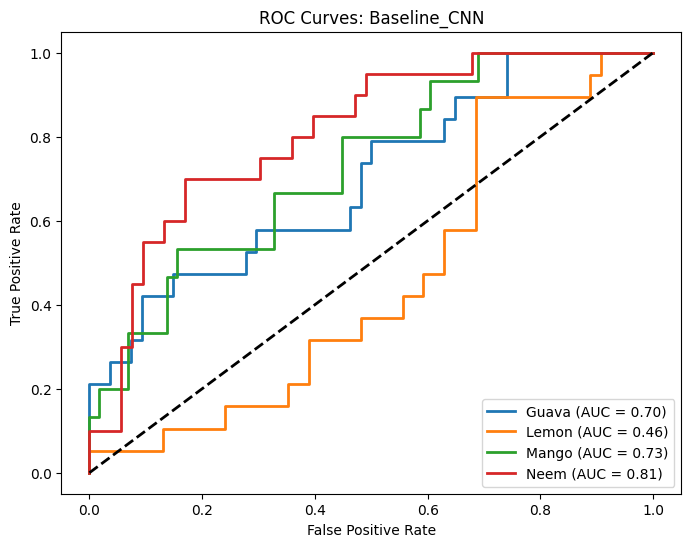

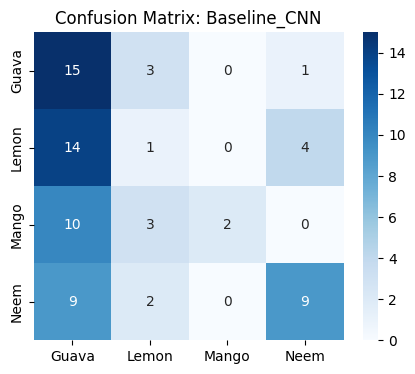


📊 Evaluating: MobileNetV2
Found 73 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


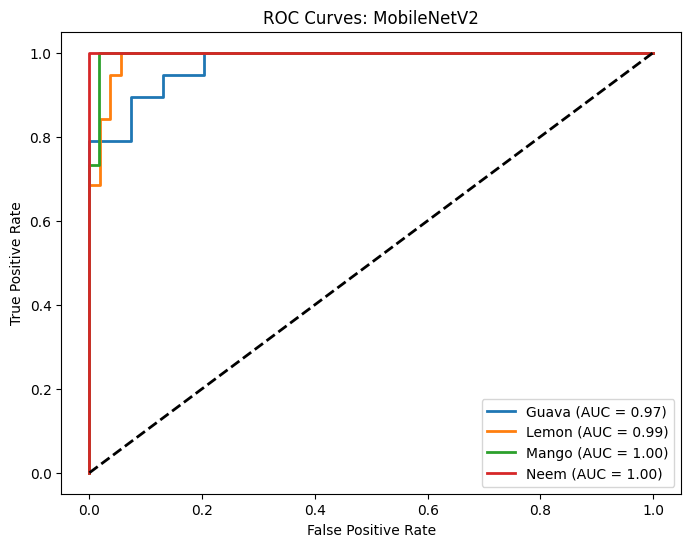

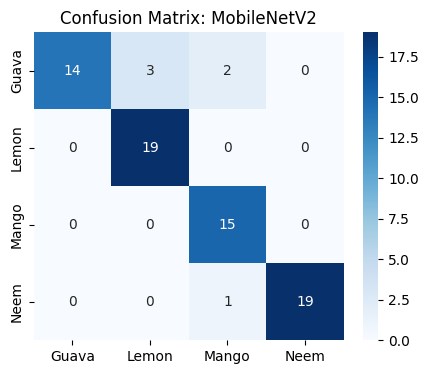


📊 Evaluating: ResNet50
Found 73 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


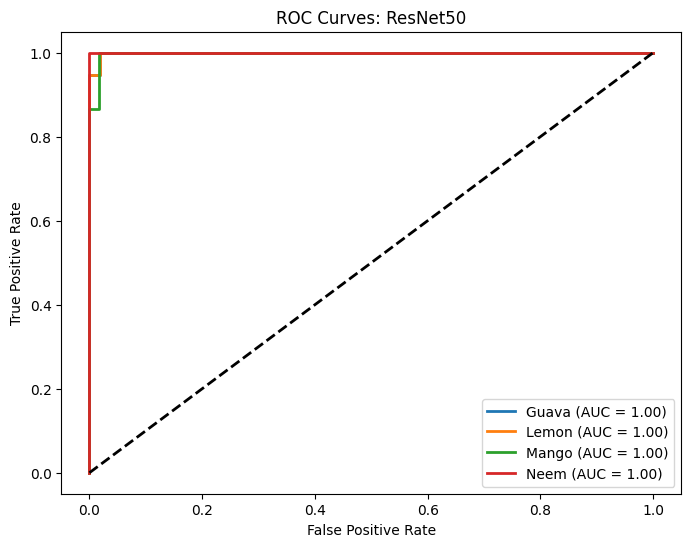

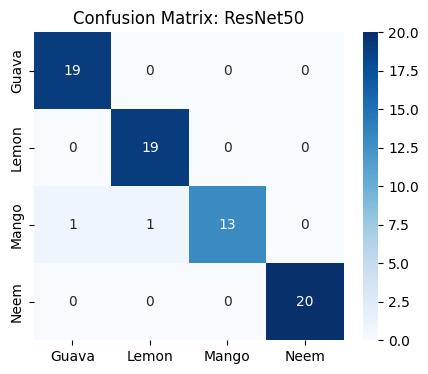


📊 Evaluating: EfficientNetB7
Found 73 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


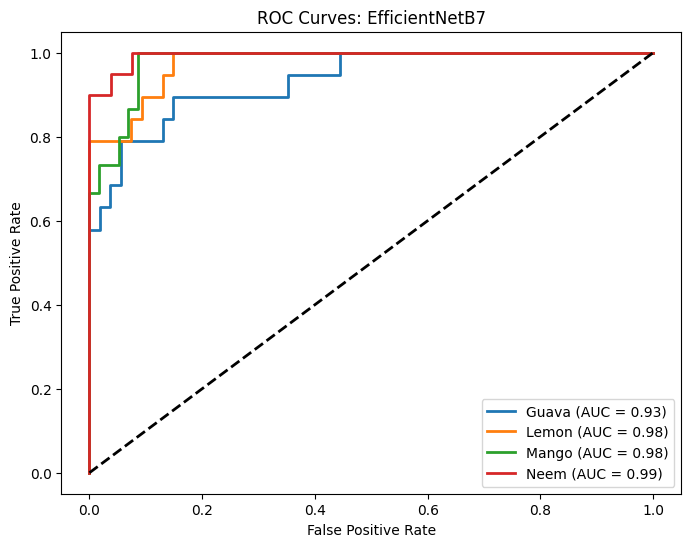

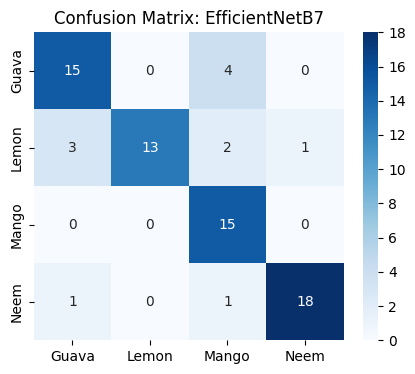

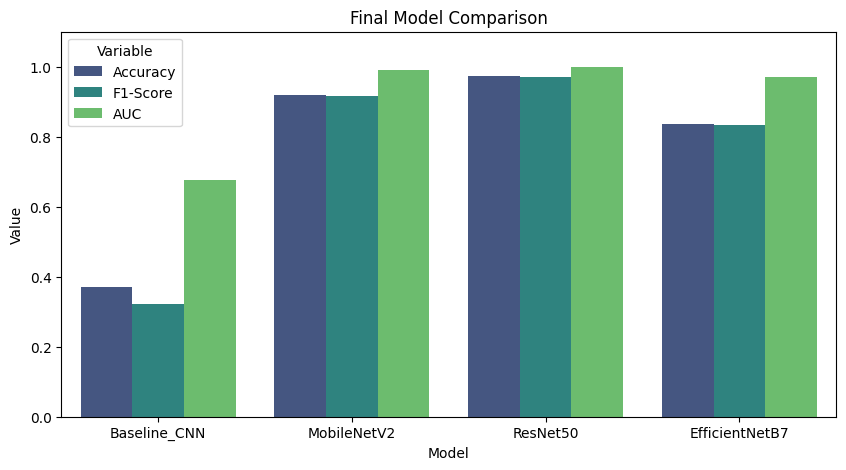


🏆 LEADERBOARD 🏆
            Model  Accuracy  F1-Score       AUC
0    Baseline_CNN  0.369863  0.320974  0.674878
1     MobileNetV2  0.917808  0.914691  0.990079
2        ResNet50  0.972603  0.969322  0.998938
3  EfficientNetB7  0.835616  0.833965  0.971239


In [6]:
# =============================================================================
# 4. EVALUATION & PERFORMANCE COMPARISON
# =============================================================================
print("\n--- Phase 2B: Detailed Evaluation ---")

comparison_metrics = []

def plot_multiclass_roc(y_true, y_pred_probs, class_names, model_name):
    n_classes = len(class_names)
    fpr, tpr, roc_auc = {}, {}, {}
    y_true_onehot = to_categorical(y_true, num_classes=n_classes)
    
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves: {model_name}')
    plt.legend(loc="lower right")
    plt.show()
    return sum(roc_auc.values()) / n_classes

# Loop through all trained temp models
for name, (ModelArch, preprocess_func, rescale_val) in models_config.items():
    model_path = f"temp_{name}.keras"
    if not os.path.exists(model_path): continue
        
    print(f"\n📊 Evaluating: {name}")
    model = load_model(model_path)
    
    # Re-create Test Gen
    if preprocess_func:
        test_gen = ImageDataGenerator(preprocessing_function=preprocess_func).flow_from_dataframe(
            test_df, x_col='file_path', y_col='species', target_size=CONF["IMG_SIZE"], batch_size=CONF["BATCH_SIZE"], class_mode='categorical', shuffle=False)
    else:
        test_gen = ImageDataGenerator(rescale=rescale_val).flow_from_dataframe(
            test_df, x_col='file_path', y_col='species', target_size=CONF["IMG_SIZE"], batch_size=CONF["BATCH_SIZE"], class_mode='categorical', shuffle=False)
            
    # Predictions
    y_pred_probs = model.predict(test_gen, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_gen.classes
    labels = list(test_gen.class_indices.keys())
    
    # Metrics
    report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
    avg_auc = plot_multiclass_roc(y_true, y_pred_probs, labels, name)
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f"Confusion Matrix: {name}")
    plt.show()
    
    comparison_metrics.append({
        'Model': name,
        'Accuracy': report['accuracy'],
        'F1-Score': report['macro avg']['f1-score'],
        'AUC': avg_auc
    })

# Final Comparison Chart
comp_df = pd.DataFrame(comparison_metrics)
plt.figure(figsize=(10, 5))
tidy = comp_df.melt(id_vars='Model').rename(columns=str.title)
sns.barplot(x='Model', y='Value', hue='Variable', data=tidy, palette='viridis')
plt.title('Final Model Comparison')
plt.ylim(0, 1.1)
plt.show()

print("\n🏆 LEADERBOARD 🏆")
print(comp_df)


--- Generating Explanations for Best Model: ResNet50 ---


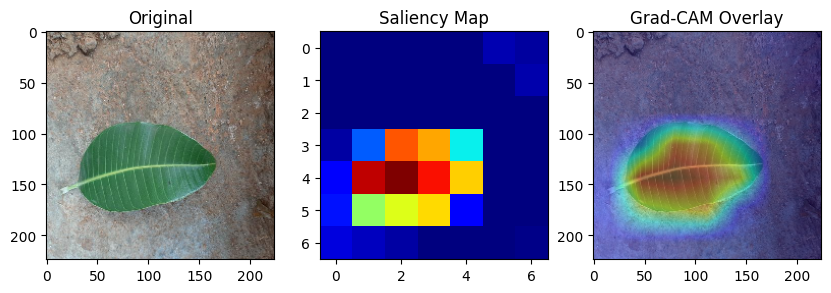


✅ PROJECT COMPLETE. Files ready for download: 'Best_Model.h5', 'class_indices.pkl'


In [7]:
# =============================================================================
# 5. EXPLAINABILITY (GRAD-CAM)
# =============================================================================
print(f"\n--- Generating Explanations for Best Model: {best_model_name} ---")

def get_gradcam_heatmap_robust(model, img_array, model_type):
    # Determine base model layer
    if model_type == 'Baseline_CNN':
        last_conv_layer = [layer.name for layer in model.layers if isinstance(layer, layers.Conv2D)][-1]
        grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer).output, model.output])
        with tf.GradientTape() as tape:
            conv_outputs, preds = grad_model(img_array)
            pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]
        grads = tape.gradient(class_channel, conv_outputs)
        conv_outputs = conv_outputs
    else:
        # Nested Transfer Learning Model
        base_model = model.layers[0]
        classifier_layers = model.layers[1:]
        with tf.GradientTape() as tape:
            base_output = base_model(img_array, training=False)
            tape.watch(base_output)
            x = base_output
            for layer in classifier_layers: x = layer(x)
            preds = x
            top_class_idx = tf.argmax(preds[0])
            top_class_channel = preds[:, top_class_idx]
        grads = tape.gradient(top_class_channel, base_output)
        conv_outputs = base_output

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Visualization
try:
    final_model = load_model('Best_Model.h5')
    sample_path = test_df.sample(1).iloc[0]['file_path']
    original_img = cv2.imread(sample_path)
    original_img = cv2.resize(original_img, CONF["IMG_SIZE"])
    img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    
    # Preprocess
    img_array = np.expand_dims(img_rgb, axis=0)
    winner_config = models_config[best_model_name]
    if winner_config[1]: img_array = winner_config[1](img_array.astype(float))
    else: img_array = img_array.astype(float) * winner_config[2]
        
    heatmap = get_gradcam_heatmap_robust(final_model, img_array, best_model_name)
    
    # Overlay
    heatmap_resized = cv2.resize(heatmap, CONF["IMG_SIZE"])
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(original_img, 0.6, heatmap_colored, 0.4, 0)
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1,3,1); plt.imshow(img_rgb); plt.title("Original")
    plt.subplot(1,3,2); plt.imshow(heatmap, cmap='jet'); plt.title("Saliency Map")
    plt.subplot(1,3,3); plt.imshow(cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB)); plt.title("Grad-CAM Overlay")
    plt.show()
    
except Exception as e:
    print(f"⚠️ Grad-CAM Warning: {e}")

print("\n✅ PROJECT COMPLETE. Files ready for download: 'Best_Model.h5', 'class_indices.pkl'")